# Working with data 2017. Class 5
## Contact
Javier Garcia-Bernardo
garcia@uva.nl

## 0. Structure
## 1 Assumptions of t-test and regression
- Normality 
- Independent and identically distributed (i.i.d.)
- Equal variance
- (for linear regression) Uncorrelated residuals


## 2.  groups
    - Compare one group vs one value
    - Compare two groups 
    - Compare two paired groups
## 3. Multiple groups
    - ANOVA
    - Multiple comparison (Tukey correction)
    
## 4.  Regressions
    - Linear regression
    - Logistic regression
    - Machine learning

In [10]:
##Some code to run at the beginning of the file, to be able to show images in the notebook
##Don't worry about this cell

#Print the plots in this screen
%matplotlib inline 

#Be able to plot images saved in the hard drive
from IPython.display import Image 

#Make the notebook wider
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:90% !important; }</style>"))

import seaborn as sns
import pylab as plt
import pandas as pd
import numpy as np
import scipy.stats

import statsmodels.formula.api as smf

In [11]:
def qq_plot(x):
    (osm, osr),(slope, intercept, r)  = scipy.stats.probplot(x, dist='norm', plot=None)
    plt.plot(osm, osr, '.', osm, slope*osm + intercept)
    plt.xlabel('Quantiles',fontsize=14)
    plt.ylabel('Quantiles Obs',fontsize=14)  

# 4. Regression
- import statsmodels.formula.api as smf
- Assumptions --> Not easy without prior understanding of statistics: http://statsmodels.sourceforge.net/devel/diagnostic.html

- Regression using dummy variables for each category ~ ANOVA


In [375]:
df = pd.read_csv("data/big3_position.csv",sep="\t")
df.head()

,Company_name,Company_ID,Big3Share,Position,Revenue,Assets,Employees,MarketCap,Exchange,TypeEnt
0,INVESCO LTD,BM40671R,17.85,1,7500000.0,NaN,7500.0,13123024.0,New York Stock Exchange (NYSE),Bank
1,ROYAL CARIBBEAN CRUISES LTD,LR30002MX,14.32,3,7500000.0,NaN,7500.0,16739323.0,New York Stock Exchange (NYSE),Industrial company
2,GENCO SHIPPING & TRADING LTD,MH30004AQ,0.14,31,350000.0,NaN,1500.0,43392.0,New York Stock Exchange (NYSE),Industrial company
3,EAGLE BULK SHIPPING INC,MH40003AQ,2.85,9,350000.0,NaN,750.0,26674.0,NASDAQ National Market,Industrial company
4,POWERSHARES DB US DOLLAR INDEX BEARISH,US*S00100679,0.00,101,NaN,NaN,NaN,44120.0,NYSE ARCA,Industrial company


## 5.1 Linear regression
- `mod = smf.ols(formula='MarketCap ~ Revenue + Employees + Revenue*Assets + C(TypeEnt)', data=df)`
- ~ means model the dependent variable/endogenous/y (left) using the independent/exogenous/x (right)
- `*` means calculate the interaction effect
- C(TypeEnt) tells the computer that TypeEnt is a categorical variable (only required if TypeEnt is a number, so not this case)

In [235]:
#How to run a regression (be careful, this is wrong)
mod = smf.ols(formula='MarketCap ~ Revenue + Employees', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              MarketCap   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     1760.
Date:                Tue, 24 Jan 2017   Prob (F-statistic):               0.00
Time:                        02:52:38   Log-Likelihood:                -59698.
No. Observations:                3300   AIC:                         1.194e+05
Df Residuals:                    3297   BIC:                         1.194e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     2.2e+06   3.12e+05      7.055      0.0

**Why is it wrong?**
- Cond. No. tells you if your dependent variables are very similar (colinearity) are or if there is something really wrong.

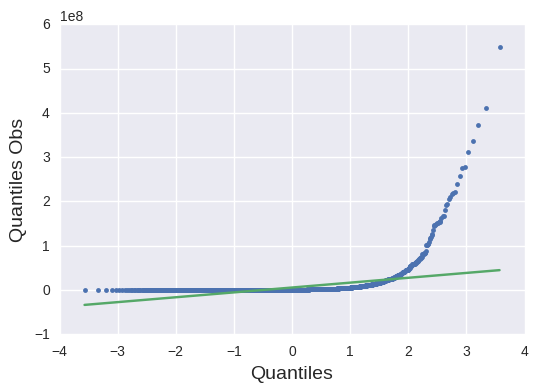

In [12]:
## Asumptions
#- Normality
qq_plot(df["MarketCap"])

In [376]:
##Let's fix that
df["logMarketcap"] = np.log(df["MarketCap"])
df["logRevenue"] = np.log(df["Revenue"])
df["logEmployees"] = np.log(df["Employees"])
df["logAssets"] = np.log(df["Assets"])

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


/opt/anaconda/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:964: RuntimeWarning: invalid value encountered in multiply
  scl = np.multiply(avg, 0) + scl
/opt/anaconda/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2490: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


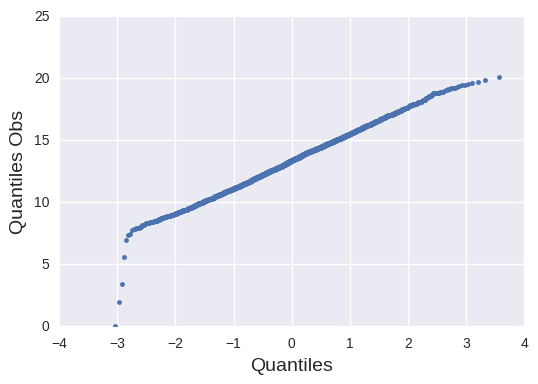

In [377]:
## Asumptions
#- Normality
qq_plot(df["logMarketcap"])

In [237]:
#Keep only finite values (otherwise we'd get a linear algebra error in our regression)
df = df.replace([np.inf, -np.inf], np.nan)
df_nonans = df.dropna(subset=["logMarketcap","logRevenue","logEmployees","logAssets"])
#Kepe only three types of entities
df_nonans = df_nonans.loc[df_nonans["TypeEnt"].isin(["Financial company","Industrial company","Bank"])]

In [238]:
#Make sure all our values are fine
df_nonans.describe()

,Big3Share,Position,Revenue,Assets,Employees,MarketCap,logMarketcap,logRevenue,logEmployees,logAssets
count,3003.000000,3003.000000,3.003000e+03,3.003000e+03,3.003000e+03,3.003000e+03,3003.000000,3003.000000,3003.000000,3003.000000
mean,11.757865,10.228771,4.096179e+06,9.579021e+06,1.148674e+04,6.730470e+06,13.701772,13.112252,7.302807,13.912946
std,7.656005,27.282358,1.654172e+07,6.816438e+07,5.363608e+04,2.606984e+07,2.040686,2.324777,2.137099,2.015391
min,0.000000,1.000000,2.000000e+00,1.381000e+03,1.000000e+00,1.000000e+00,0.000000,0.693147,0.000000,7.230563
25%,4.800000,1.000000,1.269750e+05,2.772165e+05,3.250000e+02,2.168230e+05,12.286831,11.751745,5.783825,12.532554
50%,12.400000,2.000000,5.883680e+05,1.153700e+06,1.585000e+03,9.066780e+05,13.717543,13.285108,7.368340,13.958485
75%,18.035000,5.000000,2.324281e+06,4.322288e+06,6.900000e+03,3.427924e+06,15.047465,14.658921,8.839277,15.279295
max,48.190000,165.000000,4.821300e+08,2.144316e+09,2.300000e+06,5.496596e+08,20.124810,19.993724,14.648420,21.486086


In [239]:
#Now our cond. number is okay
mod1 = smf.ols(formula='logMarketcap ~ logAssets', data=df_nonans)
res1 = mod1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:           logMarketcap   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     7040.
Date:                Tue, 24 Jan 2017   Prob (F-statistic):               0.00
Time:                        02:52:45   Log-Likelihood:                -4589.2
No. Observations:                3003   AIC:                             9182.
Df Residuals:                    3001   BIC:                             9194.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.9058      0.142     13.416      0.0

## Summary gives us info about assumptions
- Normality: Jarque-Bera (smallest = better). Test is pretty robust to deviations
- Auto-correlations of residuals: Durbin-Watson: [0-4]. 2 = no auto-correlation of residuals
- Normality of residuals: Omnibus (smallest = better)
- Multicollinearity: Cond. No. (smallest = better)

So test is telling us that the residuals are not normally distributed

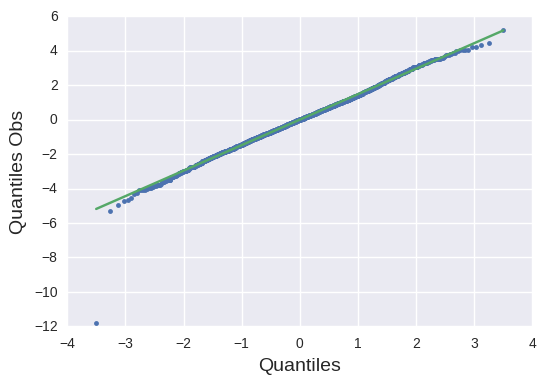

In [78]:
#Check this --> Only for the tails
qq_plot(res.resid)

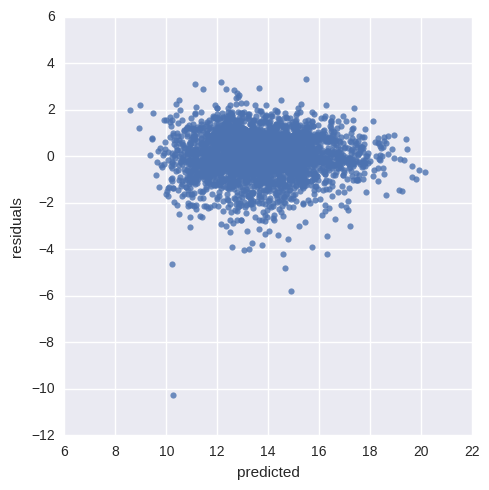

In [226]:
#Residuals are nice except for tails
df_nonans["residuals"] = res.resid
df_nonans["predicted"] = res.predict()
sns.lmplot(x="predicted",y="residuals",fit_reg=False,data=df_nonans)

(5, 22)

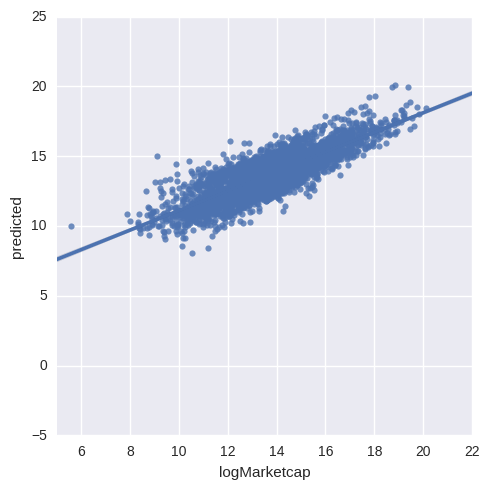

In [379]:
df_nonans["predicted"] = res1.predict()
sns.lmplot("logMarketcap","predicted",data=df_nonans)
plt.xlim((5,22))

## 5.1b Linear regression with categorical data

In [228]:
#Now our cond. number is okay
mod2 = smf.ols(formula='logMarketcap ~ logAssets  + C(TypeEnt)', data=df_nonans)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:           logMarketcap   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     1623.
Date:                Tue, 24 Jan 2017   Prob (F-statistic):               0.00
Time:                        02:39:25   Log-Likelihood:                -4247.5
No. Observations:                3013   AIC:                             8509.
Df Residuals:                    3006   BIC:                             8551.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------

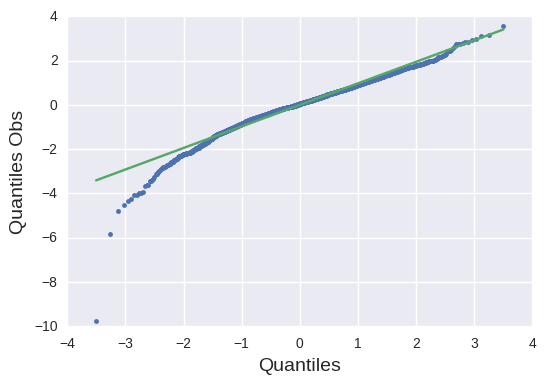

In [82]:
#Check this --> Only for the tails
qq_plot(res.resid)

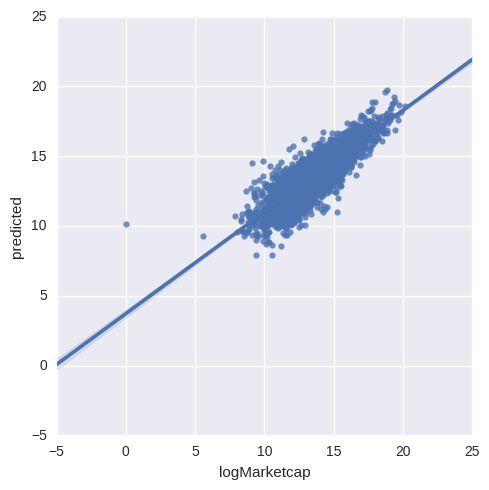

In [259]:
df_nonans["predicted"] = res2.predict()
sns.lmplot("logMarketcap","predicted",data=df_nonans)

## 5.1c Linear regression with interaction effects

In [260]:
#Now our cond. number is okay. Not okay
mod3 = smf.ols(formula='logMarketcap ~ logAssets*logEmployees  + C(TypeEnt)', data=df_nonans)
res3 = mod3.fit()
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:           logMarketcap   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     2006.
Date:                Tue, 24 Jan 2017   Prob (F-statistic):               0.00
Time:                        03:12:47   Log-Likelihood:                -4196.5
No. Observations:                3003   AIC:                             8405.
Df Residuals:                    2997   BIC:                             8441.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

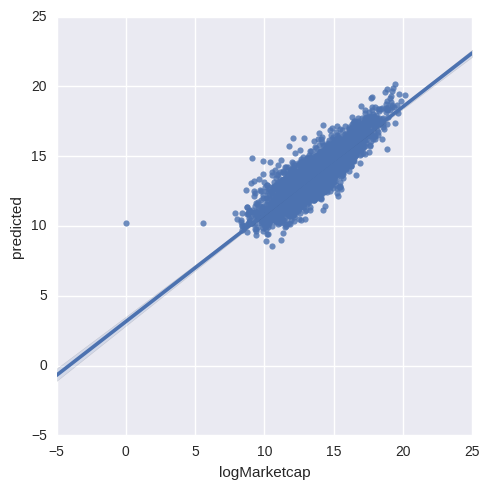

In [261]:
df_nonans["predicted"] = res3.predict()
sns.lmplot("logMarketcap","predicted",data=df_nonans)

## 5.2 Combine different models in a table

In [230]:
from statsmodels.iolib.summary2 import summary_col
dfoutput = summary_col([res1,res2,res3],stars=True)
dfoutput

/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/iolib/summary2.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/iolib/summary2.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/iolib/summary2.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res

,logMarketcap I,logMarketcap II,logMarketcap III
C(TypeEnt)[T.Financial company],,1.5336***,1.5596***
,,(0.0874),(0.0865)
C(TypeEnt)[T.Foundation/Research institute],,1.3763**,1.1647**
,,(0.5767),(0.5713)
C(TypeEnt)[T.Industrial company],,1.8631***,1.6387***
,,(0.0659),(0.0726)
C(TypeEnt)[T.Insurance company],,2.0360***,1.7674***
,,(0.4997),(0.4952)
C(TypeEnt)[T.Venture capital],,1.3988**,1.3489**
,,(0.5764),(0.5698)


## 5.3 Linear Mixed Effects Models

More info: http://nbviewer.jupyter.org/urls/umich.box.com/shared/static/6tfc1e0q6jincsv5pgfa.ipynb
More info: http://nbviewer.jupyter.org/urls/umich.box.com/shared/static/lc6uf6dmabmitjbup3yt.ipynb

Combine:
- Fixed effects: Normal regression
- Random effects:
    - Factors likely to introduce systematic variation
    - Different experimental units (groups) have different intercepts of slopes.

For instance, we want to measure the relationship between unemployment and productivity for different regions in many countries. Each country may have their own "structural" unemployment, we can get rid of this variability by using country as the random effects.

Another example, we measure the relationship between two variables at different years. We don't really care about how they change in time, we only care about how one variable affect the other. We can use time as the random effect.

To allow for random slopes: `re_formula` parameter (see first notebook in the more info example)


In [241]:
Image(url="http://zoonek2.free.fr/UNIX/48_R/g1096.png")

In [307]:
#https://hlplab.wordpress.com/tag/regression/
print("Random slopes")
Image(url="https://hlplab.files.wordpress.com/2011/05/simpsons-paradox.png",width=800)   

Random slopes


In [289]:
#Random intercepts for different type of entities. We can also give random slopes
mod = smf.mixedlm(formula='logMarketcap ~ logAssets*logEmployees',groups="TypeEnt", data=df_nonans)
res4 = mod.fit()
print(res4.summary())

/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:160: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._params = np.zeros(self.k_tot)


              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   logMarketcap
No. Observations:    3003      Method:               REML        
No. Groups:          3         Scale:                0.9598      
Min. group size:     253       Likelihood:           -4218.3680  
Max. group size:     2484      Converged:            Yes         
Mean group size:     1001.0                                      
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.258    0.661  4.931 0.000  1.963  4.553
logAssets               0.674    0.030 22.299 0.000  0.615  0.733
logEmployees           -0.248    0.051 -4.900 0.000 -0.347 -0.149
logAssets:logEmployees  0.023    0.004  6.644 0.000  0.017  0.030
Intercept RE            0.852    1.236                           



In [273]:
res4.random_effects

,Intercept
Bank,-1.062645
Financial company,0.491003
Industrial company,0.571679


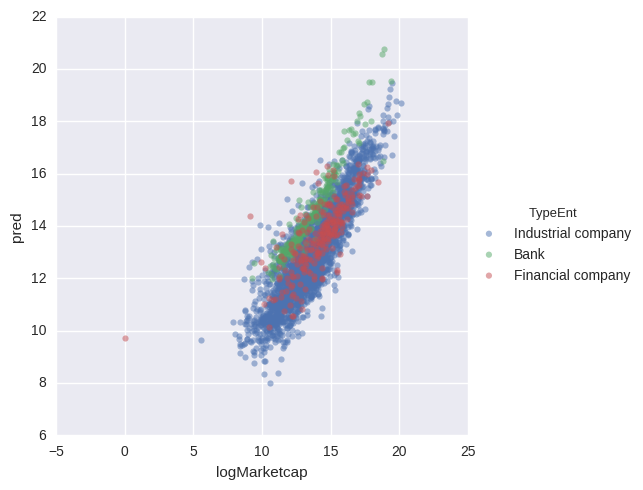

In [302]:
df_nonans["pred"] = 3.258  + 0.674*df_nonans["logAssets"] -0.248*df_nonans["logEmployees"] + 0.023*df_nonans["logAssets"]*df_nonans["logEmployees"]
sns.lmplot(x= "logMarketcap",y="pred",data=df_nonans,fit_reg=False,hue="TypeEnt",scatter_kws={"alpha":0.5})

In [381]:
df = pd.read_csv("data/it_es.csv",sep="\t")
df = df.loc[df["Year"]>2004]
df.head()

,Metropolitan areas,Country,LABOUR_PRODUCTIVITY,UNEMP_R,Year
5,Madrid,ES,88755.16,6.83,2005
6,Madrid,ES,89422.50,6.40,2006
7,Madrid,ES,90502.91,6.29,2007
8,Madrid,ES,91649.87,8.74,2008
9,Madrid,ES,94737.54,14.12,2009


In [370]:
#Random intercepts for different type of entities. We can also give random slopes
mod = smf.mixedlm(formula='LABOUR_PRODUCTIVITY ~ UNEMP_R',re_formula="Year",groups="Country", data=df)
res4 = mod.fit()
print(res4.summary())

/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:160: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._params = np.zeros(self.k_tot)
/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:160: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._params = np.zeros(self.k_tot)
/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda/anaconda3/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:160: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._params = np.zeros(self.k_tot)
/opt/anaconda/anaconda

                         Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        LABOUR_PRODUCTIVITY
No. Observations:         179            Method:                    REML               
No. Groups:               2              Scale:                     211213227.3669     
Min. group size:          82             Likelihood:                -1967.4042         
Max. group size:          97             Converged:                 Yes                
Mean group size:          89.5                                                         
---------------------------------------------------------------------------------------
                           Coef.       Std.Err.     z    P>|z|    [0.025       0.975]  
---------------------------------------------------------------------------------------
Intercept                 101040.888  1414921.803  0.071 0.943 -2672154.887 2874236.662
UNEMP_R                    -1103.073      220.548 -5.002 

In [371]:
res4.random_effects

,Intercept,Year
ES,-862.371778,-3.422424
IT,-17.104176,3.269262


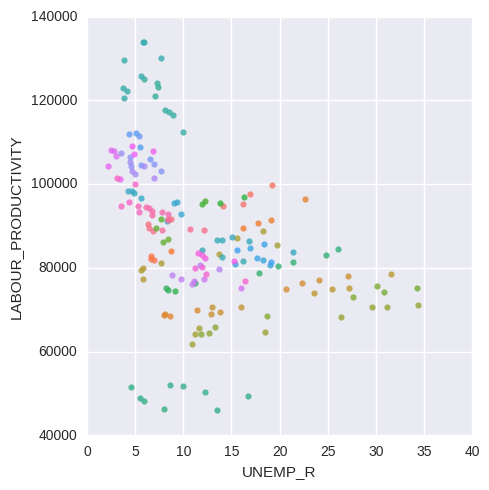

In [372]:
df["CityYear"] = df["Metropolitan areas"] + df["Year"].astype(str)
sns.lmplot("UNEMP_R","LABOUR_PRODUCTIVITY",data=df,hue="CityYear",fit_reg=False,legend=False)

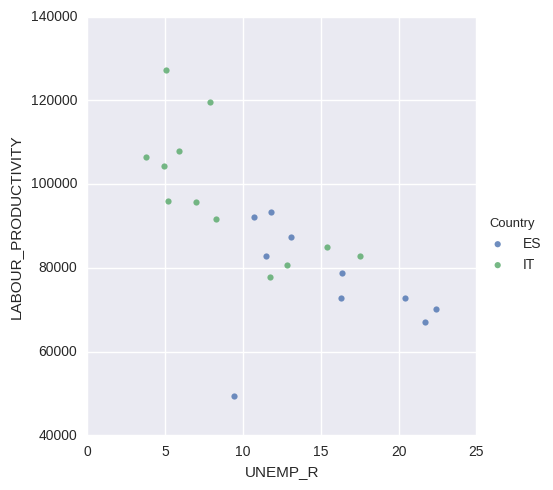

In [385]:
a = df.groupby(["Country","Metropolitan areas"]).mean().reset_index()
sns.lmplot("UNEMP_R","LABOUR_PRODUCTIVITY",data=a,hue="Country",fit_reg=False)
#mod = smf.ols(formula='LABOUR_PRODUCTIVITY ~ UNEMP_R', data=a)
#print(mod.fit().summary())

## 5.2 Logistic regression
- The dependent variable is categorical (usually: 0/1).
- Let's predict survival in titanic

In [93]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/6/6d/Exam_pass_logistic_curve.jpeg")

In [134]:
df = pd.read_csv("data/Titanic.csv")
df = df.dropna()
df.head()

,Unnamed: 0,Name,PClass,Age,Sex,Survived,SexCode
0,1,"Allen, Miss Elisabeth Walton",1st,29.00,female,1,1
1,2,"Allison, Miss Helen Loraine",1st,2.00,female,0,1
2,3,"Allison, Mr Hudson Joshua Creighton",1st,30.00,male,0,0
3,4,"Allison, Mrs Hudson JC (Bessie Waldo Daniels)",1st,25.00,female,0,1
4,5,"Allison, Master Hudson Trevor",1st,0.92,male,1,0


In [205]:
#Now our cond. number is okay. Not okay
mod = smf.logit(formula='Survived ~ C(PClass) + C(Sex)', data=df)
res2 = mod.fit()
print(res2.summary())

Optimization terminated successfully.
         Current function value: 0.478568
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  756
Model:                          Logit   Df Residuals:                      752
Method:                           MLE   Df Model:                            3
Date:                Tue, 24 Jan 2017   Pseudo R-squ.:                  0.2944
Time:                        01:55:16   Log-Likelihood:                -361.80
converged:                       True   LL-Null:                       -512.79
                                        LLR p-value:                 3.713e-65
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            2.1628      0.219      9.873      0.000         1.733     2.592
C(PClass)[T

### Odds ratios (calculated taking the exp of the parameters)
- Intercept -> Odds of a 1st class female
- Odds of a female in second class -> 8.695166 * 0.452182

In [206]:
##Odds ratios
print(np.exp(res2.params))

Intercept           8.695166
C(PClass)[T.2nd]    0.452182
C(PClass)[T.3rd]    0.155614
C(Sex)[T.male]      0.072710
dtype: float64


In [216]:
def calc_prob(odds):
    return odds/(odds+1)

In [220]:
#Female in first class
print("Female, 1st class")
c = df.loc[(df["Sex"]=="female") & (df["PClass"]=="1st")]["Survived"]
print("Odds: ",calc_prob(8.695166), "Real: ", np.sum(c)/len(c),"\n")

#Female in second class
print("Female, 2nd class")
c = df.loc[(df["Sex"]=="female") & (df["PClass"]=="2nd")]["Survived"]
print("Odds: ",calc_prob(8.695166*0.452182), "Real: ", np.sum(c)/len(c),"\n")

#Female in third class
print("Female, 3rd class")
c = df.loc[(df["Sex"]=="female") & (df["PClass"]=="3rd")]["Survived"]
print("Odds: ",calc_prob(8.695166*0.155614), "Real: ", np.sum(c)/len(c),"\n")

Female, 1st class
Odds:  0.8968558145368527 Real:  0.9504950495049505 

Female, 2nd class
Odds:  0.7972341748798099 Real:  0.8823529411764706 

Female, 3rd class
Odds:  0.575026800432385 Real:  0.45098039215686275 



In [219]:
#Female in first class
print("male, 1st class")
c = df.loc[(df["Sex"]=="male") & (df["PClass"]=="1st")]["Survived"]
print("Odds: ",calc_prob(8.695166*0.072710), "Real: ", np.sum(c)/len(c),"\n")

#Female in second class
print("male, 2nd class")
c = df.loc[(df["Sex"]=="male") & (df["PClass"]=="2nd")]["Survived"]
print("Odds: ",calc_prob(8.695166*0.452182*0.072710), "Real: ", np.sum(c)/len(c),"\n")

#Female in third class
print("male, 3rd class")
c = df.loc[(df["Sex"]=="male") & (df["PClass"]=="3rd")]["Survived"]
print("Odds: ",calc_prob(8.695166*0.155614*0.072710), "Real: ", np.sum(c)/len(c),"\n")



male, 1st class
Odds:  0.3873395631715325 Real:  0.344 

male, 2nd class
Odds:  0.2223230610115488 Real:  0.16535433070866143 

male, 3rd class
Odds:  0.08957087766669306 Real:  0.14814814814814814 



## Lots and lots of examples:
    https://github.com/statsmodels/statsmodels/wiki/Examples#linear-mixed-models

# 6. Machine learning
- Let the computer "figure it out"
- Regression: http://scikit-learn.org/stable/supervised_learning.html#supervised-learning
- Great when you have many variables. No overfitting!
- You can use it to classify text, to cluster numbers, for regression, to reduce the number of parameters, etc
- The Python library is amazing.

In [128]:
print("For instance here we have 10 variables measuring the same, blue = SVR, red = linear regression. The weights are not good for linear regression")
Image(url="http://www.alivelearn.net/wp-content/uploads/2012/11/weight.jpg")

For instance here we have 10 variables measuring the same, blue = SVR, red = linear regression. The weights are not good for linear regression


In [249]:
from sklearn import svm
y = df_nonans["logMarketcap"]
X = df_nonans.loc[:, ["logAssets","logEmployees","logRevenue"]]

clf = svm.SVR(kernel="linear")
clf.fit(X, y) 

predicted_values = clf.predict(X)
df_nonans["predicted"] = predicted_values
print(clf.intercept_)
print(clf.coef_)

[ 1.92307445]
[[ 0.596637    0.05438561  0.23767838]]


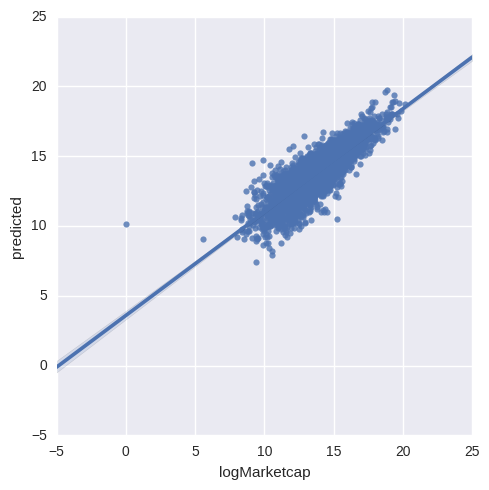

In [250]:
sns.lmplot("logMarketcap","predicted",data=df_nonans)

In [243]:
#Now our cond. number is okay. Not okay
mod = smf.ols(formula='logMarketcap ~ logAssets + logEmployees + logRevenue', data=df_nonans)
res2 = mod.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:           logMarketcap   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     2682.
Date:                Tue, 24 Jan 2017   Prob (F-statistic):               0.00
Time:                        03:00:44   Log-Likelihood:                -4445.1
No. Observations:                3003   AIC:                             8898.
Df Residuals:                    2999   BIC:                             8922.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        2.1468      0.146     14.696   